In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import albumentations as A

import tensorflow_addons as tfa

/home/haowei/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [4]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [5]:
# common params
IMAGE_SIZE = 299
BATCH_SIZE = 32
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 500

## Data augmentation

In [6]:
transform = A.Compose([
    A.Flip(p=0.5),
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
    A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, erosion_rate=0.2, p=0.5),
    A.HueSaturationValue(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

In [7]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.pipeline = []
        self.image_names= []
        self.record_list= []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        input_file_all = []
        for line in input_file:
            input_file_all.append(line)
        input_file_train, input_file_test = train_test_split(input_file_all, test_size=0.2, random_state=0)

        self.pipeline = [input_file_train, input_file_test]

        for idx, pipe in enumerate(self.pipeline):
            image_names_ = []
            record_list_ = []
            object_num_list_ = []


            for line in pipe:
                line = line.strip()
                ss = line.split(' ')

                count = 1
                flag = 0
                for i in range(5, len(ss), 5):
                    if(int(ss[i]) == 14):
                        count = 1
                        break
                    elif(int(ss[i]) == 6 or int(ss[i]) == 8):
                        count = 2
                        flag = 1
                    else:
                        if(flag):
                            count = 2
                        else:
                            count = 8

                for _ in range(count):
                    image_names_.append(ss[0])

                    record_list_.append([float(num) for num in ss[1:]])

                    object_num_list_.append(min(len(record_list_[-1])//5, 
                                                          MAX_OBJECTS_PER_IMAGE))
                    if len(record_list_[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                        # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                        record_list_[-1] = record_list_[-1] +\
                        [0., 0., 0., 0., 0.]*\
                        (MAX_OBJECTS_PER_IMAGE-len(record_list_[-1])//5)
                        
                    elif len(record_list_[-1]) > MAX_OBJECTS_PER_IMAGE*5:
                    # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                        record_list_[-1] = record_list_[-1][:MAX_OBJECTS_PER_IMAGE*5]
            self.image_names.append(image_names_) # train, test
            self.record_list.append(record_list_) # train, test
            self.object_num_list.append(object_num_list_) # train, test
    
                
    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
        bboxes = raw_labels[:object_num, 0:4]
        category_ids = raw_labels[:object_num, 4]

        # image augmentation
        transformed = transform(image=image.numpy(), bboxes=bboxes.numpy(), category_ids=category_ids.numpy())

        image = tf.keras.applications.inception_resnet_v2.preprocess_input(transformed['image'])

        object_num = len(bboxes)

        bboxes = transformed['bboxes']
        bboxes = np.vstack([bboxes, np.zeros((MAX_OBJECTS_PER_IMAGE - object_num, 4))])

        xmin = bboxes[:, 0]
        ymin = bboxes[:, 1]
        xmax = bboxes[:, 2]
        ymax = bboxes[:, 3]

        class_num = transformed['category_ids']
        class_num = np.hstack([class_num, np.zeros((MAX_OBJECTS_PER_IMAGE - object_num),)])

        xcenter = (xmin + xmax) * 1.0 / 2.0
        ycenter = (ymin + ymax) * 1.0 / 2.0

        box_w = xmax - xmin
        box_h = ymax - ymin

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, tf.cast(labels, tf.float32), tf.cast(object_num, tf.int32)

    def _data_preprocess_valid(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def tf_data_preprocess(self, image_name, raw_labels, object_num):
        tf_tensor = tf.py_function(self._data_preprocess, (image_name, raw_labels, object_num), Tout=(tf.float32, tf.float32, tf.int32))
        return tf_tensor

    def generate(self):
        out = []

        for image_names, record_list, object_num_list in zip(self.image_names, self.record_list, self.object_num_list):
            dataset = tf.data.Dataset.from_tensor_slices((image_names, 
                                                          np.array(record_list), 
                                                          np.array(object_num_list)))
            dataset = dataset.shuffle(100000)
            dataset = dataset.map(self.tf_data_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
            dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
            dataset = dataset.prefetch(buffer_size=200)
            out.append(dataset)

        return out[0], out[1]

In [8]:
dataset_train, dataset_val = DatasetGenerator().generate()

## Model

In [9]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    #x = tfa.activations.mish(x)
    return x

we use inception-resnet-v2 model pre-trained on imagenet as the feature extractor.

In [10]:
inception_resnet_v2 = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
inception_resnet_v2.trainable = False

In [11]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = inception_resnet_v2(img_inputs)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = tfa.activations.mish(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [12]:
YOLO.summary()

Model: "YOLO"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v2 (Functional (None, 8, 8, 1536)   54336736    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 8, 8, 1024)   14156800    inception_resnet_v2[0][0]        
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 8, 8, 1024)   4096        conv2d_203[0][0]                 
_______________________________________________________________________________________________

## Calculate loss (same with TA's notebook)

In [13]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [14]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss / BATCH_SIZE

In [15]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])
    
    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def giou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])
    
    return tfa.losses.giou_loss(boxes1 ,boxes2)
    
def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

## Process output

In [17]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    x_min_set = []
    x_max_set = []
    y_min_set = []
    y_max_set = []
    class_nums = []
    confs = []

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))
    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    confs.append(max_conf)
    
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]
    class_nums.append(class_num)

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    x_min = xcenter - w/2.0
    y_min = ycenter - h/2.0
    x_min_set.append(x_min)
    y_min_set.append(y_min)

    x_max = x_min + w
    y_max = y_min + h
    x_max_set.append(x_max)
    y_max_set.append(y_max)

    # choose others bboxes
    index = np.argsort(-P.flatten())[1:20]
    print(P.flatten()[np.argsort(-P.flatten())[:5]])
    for i in index:
        conf = P.flatten()[i]
        if conf < 0.03:
            break
        confs.append(conf)
        index = np.unravel_index(i, P.shape)

        class_num = index[3]
        class_nums.append(class_num)

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0
        x_min_set.append(x_min)
        y_min_set.append(y_min)

        xmax = xmin + w
        ymax = ymin + h
        x_max_set.append(x_max)
        y_max_set.append(y_max)

    return x_min_set, y_min_set, x_max_set, y_max_set, class_nums, confs

def single_bbox_iou(boxes1, boxes2):
    
#     print("box1", boxes1)
#     print("box2", boxes2)
    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[2:], boxes2[2:])
    
    #print(lu)
    #print(rd)
    #intersection
    intersection = rd - lu 
    #print("intersection",intersection)
    #the size of the intersection area
    inter_square = tf.cast(intersection[0], tf.float32) * tf.cast(intersection[1], tf.float32)
    #print("inter_square", inter_square)
    mask = tf.cast(intersection[0] > 0, tf.float32) * tf.cast(intersection[1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = tf.abs(tf.cast((boxes1[2] - boxes1[0]) * (boxes1[3] - boxes1[1]), tf.float32))
    square2 = tf.abs(tf.cast((boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1]), tf.float32))
    #print("square1", square1)
    #print("square2", square2)
    return inter_square/(square1 + square2 - inter_square + 1e-6)

def process_outputs_nml(outputs):
    """
    Process YOLO outputs into bou
    """

    x_min_set = []
    x_max_set = []
    y_min_set = []
    y_max_set = []
    class_nums = []
    confs = []

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))
    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    
    #choose the most confidence one
    max_conf = np.max(P)
    confs.append(max_conf)
    
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]
    class_nums.append(class_num)

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    x_min = xcenter - w/2.0
    y_min = ycenter - h/2.0
    x_min_set.append(x_min)
    y_min_set.append(y_min)

    x_max = x_min + w
    y_max = y_min + h
    x_max_set.append(x_max)
    y_max_set.append(y_max)
    
    
    index_10 = np.argsort(-P.flatten())[1:20]
    print(P.flatten()[np.argsort(-P.flatten())[:5]])
    for i in index_10:
        conf = P.flatten()[i]
        if conf < 0.05:
            break
        index = np.unravel_index(i, P.shape)

        class_num = index[3]

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h
        
        flag = True
        for pre_boxID in range(len(xmins)):
            box_pre = tf.stack([xmins[pre_boxID], ymins[pre_boxID], xmaxs[pre_boxID], ymaxs[pre_boxID]])
            box_cur = tf.stack([xmin, ymin, xmax, ymax])
            iou_pre = single_bbox_iou(box_pre, box_cur)
            print(iou_pre)
            if(iou_pre > 0.3):
                flag = False
                break
        if(flag):
            x_min_set.append(xmin)
            y_min_set.append(ymin)
            x_max_set.append(xmax)
            y_max_set.append(ymax)
            class_nums.append(class_num)
            confs.append(conf)
        
    return xmins, ymins, xmaxs, ymaxs, class_nums, confs

## Create dataset

In [30]:
dataset_train, dataset_val = DatasetGenerator().generate()

## Checkpoint

In [31]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [32]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=50, checkpoint_name='yolo')

In [33]:
ckpt.restore(manager.latest_checkpoint)
#ckpt.restore('./ckpts/YOLO\\yolo-44')

In [ ]:
def visualize(img_num):
    # 1, 2, 10, 18, 22, 25, 27, 28, 29, 31, 37, 313, 316
    np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/{img_num:06}.jpg')
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    # np_img = np_img / 255.0 * 2 - 1

    np_img = tf.keras.applications.inception_resnet_v2.preprocess_input(np_img)

    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

    y_pred = YOLO(np_img, training=False)
    xmins, ymins, xmaxs, ymaxs, class_nums, confs = process_outputs_nml(y_pred)

    for i in range(len(xmins)):
        xmin, ymin, xmax, ymax, class_num, conf = xmins[i], ymins[i], xmaxs[i], ymaxs[i], class_nums[i], confs[i]
        class_name = classes_name[class_num]
        color = (255, 0, 255)
        if i == 0:
            color = (0, 255, 255)
        elif i==1:
            color = (0, 0, 255)
        elif i==2:
            color = (0, 255, 0)
        elif i==3:
            color = (255, 0, 0)
        else:
            color = (255, 255, 0)
        cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 2)
        cv2.putText(resized_img, class_name, (0, 200-30*i), 2, 1, color, 2)

    plt.imshow(resized_img)
    plt.show()

## Start training

In [23]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [24]:
@tf.function
def valid_step(image, labels, objects_num):
    outputs = YOLO(image, training=False)
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = tf.concat([class_probs, confs, boxes], 3)

    return yolo_loss(predicts, labels, objects_num)

In [25]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)
    
    for idx, (image, labels, objects_num) in enumerate(dataset_train):
        print('\r Batch: {}'.format(idx), end='')
        train_step(image, labels, objects_num)

    print()
    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), int(ckpt.epoch), train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

    print("start validation...")
    valid_loss = 0
    for idx, (image, labels, objects_num) in enumerate(dataset_val):
        print('\r Batch: {}'.format(idx), end='')
        valid_loss += valid_step(image, labels, objects_num)
    print()
    print("Epoch {}: validation loss {:.2f}".format(int(ckpt.epoch), (valid_loss/31)))
    
    # if int(ckpt.epoch) % 5 == 0:
    visualize(2)
    visualize(1)

2021-11-27 15:43:30.214122, start training.
 Batch: 1060
2021-11-27 15:50:45.201530, Epoch 52: loss 10.12
Saved checkpoint for epoch 52: ./ckpts/YOLO/yolo-52
start validation...
 Batch: 30
Epoch 52: validation loss 18.73


error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [34]:
visualize(2)
visualize(1)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-22')

[0.12724689 0.10064947 0.06876022 0.06237817 0.0590418 ]
tf.Tensor(1.0000001, shape=(), dtype=float32)
tf.Tensor(0.2391357, shape=(), dtype=float32)
tf.Tensor(0.56367314, shape=(), dtype=float32)
tf.Tensor(0.35358635, shape=(), dtype=float32)


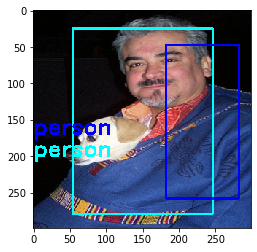

[0.22274385 0.07124776 0.05427312 0.03697135 0.03633217]
tf.Tensor(0.4505965, shape=(), dtype=float32)
tf.Tensor(0.4385813, shape=(), dtype=float32)


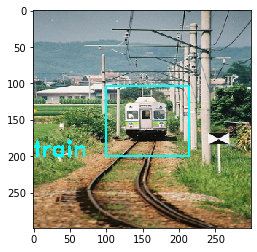

[0.08855226 0.07865001 0.07674613 0.07191461 0.06240248]
tf.Tensor(0.2860339, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.2860339, shape=(), dtype=float32)
tf.Tensor(0.9999999, shape=(), dtype=float32)
tf.Tensor(0.5663131, shape=(), dtype=float32)
tf.Tensor(0.5663131, shape=(), dtype=float32)


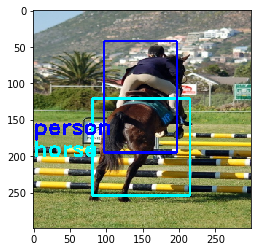

[0.21374111 0.11268053 0.08882005 0.07189098 0.05669408]
tf.Tensor(0.32633325, shape=(), dtype=float32)
tf.Tensor(0.2927375, shape=(), dtype=float32)
tf.Tensor(0.2702806, shape=(), dtype=float32)
tf.Tensor(0.47227326, shape=(), dtype=float32)
tf.Tensor(0.19567695, shape=(), dtype=float32)
tf.Tensor(0.5987652, shape=(), dtype=float32)


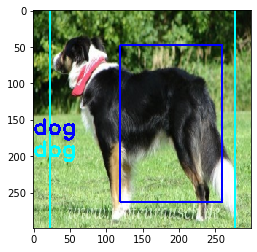

[0.11998825 0.06631562 0.05918754 0.05369746 0.05140504]
tf.Tensor(0.3661535, shape=(), dtype=float32)
tf.Tensor(0.16818479, shape=(), dtype=float32)
tf.Tensor(0.11562278, shape=(), dtype=float32)
tf.Tensor(0.07864322, shape=(), dtype=float32)
tf.Tensor(0.16818479, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


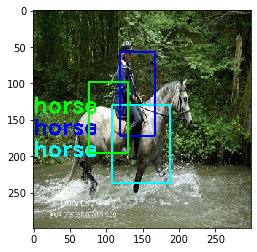

[0.10351776 0.04086648 0.03829072 0.03399081 0.0319755 ]


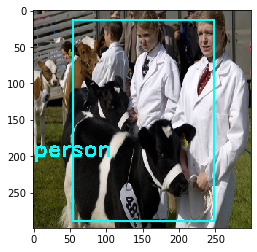

[0.15378197 0.14697646 0.12231492 0.12049414 0.0654205 ]
tf.Tensor(0.48631093, shape=(), dtype=float32)
tf.Tensor(0.31719142, shape=(), dtype=float32)
tf.Tensor(0.23339781, shape=(), dtype=float32)
tf.Tensor(0.03357258, shape=(), dtype=float32)
tf.Tensor(0.03472376, shape=(), dtype=float32)


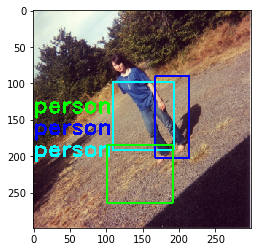

[0.4062659  0.16490479 0.14529471 0.12758428 0.0468608 ]
tf.Tensor(0.2813517, shape=(), dtype=float32)
tf.Tensor(0.2794719, shape=(), dtype=float32)
tf.Tensor(0.58160067, shape=(), dtype=float32)
tf.Tensor(0.270804, shape=(), dtype=float32)
tf.Tensor(0.62212396, shape=(), dtype=float32)


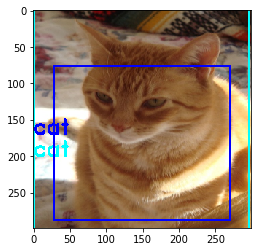

[0.14786336 0.13396138 0.1057006  0.08892282 0.06929213]
tf.Tensor(0.46369052, shape=(), dtype=float32)
tf.Tensor(0.6353965, shape=(), dtype=float32)
tf.Tensor(0.38471812, shape=(), dtype=float32)
tf.Tensor(0.34685636, shape=(), dtype=float32)
tf.Tensor(-0.0, shape=(), dtype=float32)
tf.Tensor(-0.0, shape=(), dtype=float32)
tf.Tensor(0.08479146, shape=(), dtype=float32)
tf.Tensor(0.27159443, shape=(), dtype=float32)
tf.Tensor(-0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


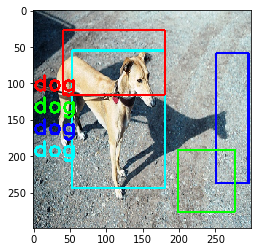

[0.2362668  0.09413181 0.07083113 0.07033583 0.03720902]
tf.Tensor(0.5723379, shape=(), dtype=float32)
tf.Tensor(0.57851917, shape=(), dtype=float32)
tf.Tensor(0.695811, shape=(), dtype=float32)


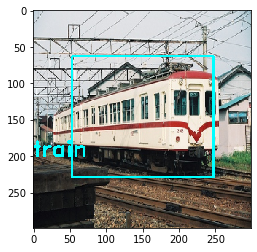

[0.19535674 0.11900459 0.06195125 0.06157621 0.04815125]
tf.Tensor(0.684095, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.50030375, shape=(), dtype=float32)


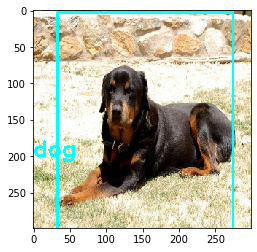

[0.10113463 0.06477769 0.0449613  0.03575829 0.03460957]
tf.Tensor(-0.0, shape=(), dtype=float32)


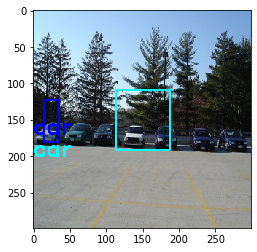

[0.22891778 0.11143492 0.08645965 0.07271393 0.05536451]
tf.Tensor(0.32327724, shape=(), dtype=float32)
tf.Tensor(0.46199358, shape=(), dtype=float32)
tf.Tensor(0.06516909, shape=(), dtype=float32)
tf.Tensor(0.34176007, shape=(), dtype=float32)


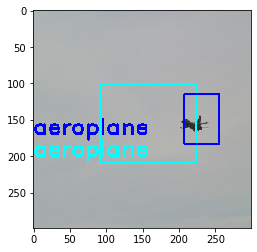

In [ ]:
for i in [1, 2, 10, 18, 22, 25, 27, 28, 29, 31, 37, 313, 316]:
    visualize(i)

## Generate output file

In [ ]:
test_img_files = open('./comp2/pascal_voc_testing_data.txt')
test_img_dir = './comp2/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

In [ ]:
output_file = open('./test_prediction4.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmins, ymins, xmaxs, ymaxs, class_nums, confs = process_outputs(prediction_step(test_img[i:i+1]))

        for j in range(len(xmins)):
            xmin, ymin, xmax, ymax, class_num, conf = xmins[j], ymins[j], xmaxs[j], ymaxs[j], class_nums[j], confs[j]
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

[0.1274308  0.10227715 0.06691038 0.06371556 0.05595805]
[0.21433878 0.0674127  0.05744004 0.03535397 0.03496751]
[0.03509493 0.02929865 0.02740741 0.0256253  0.02403139]
[0.07281209 0.06369188 0.06351878 0.05962599 0.04953848]
[0.06788966 0.03925732 0.03477191 0.03182792 0.03151823]
[0.10663762 0.1049541  0.08018196 0.06644061 0.05663729]
[0.09435571 0.0812557  0.07907852 0.07369041 0.06101131]
[0.14562021 0.09288184 0.09278065 0.05388797 0.04622337]
[0.08374981 0.07311987 0.06616984 0.06353612 0.0608896 ]
[0.03879912 0.0377955  0.03749345 0.0331604  0.02996134]
[0.19065118 0.14707004 0.08395007 0.05220714 0.0469989 ]
[0.21636634 0.11356388 0.08768152 0.07706706 0.06788707]
[0.12834668 0.06840204 0.06129166 0.05329236 0.05272135]
[0.10060837 0.04433136 0.03912468 0.03645165 0.03513565]
[0.15687253 0.14997283 0.12351458 0.10870729 0.05502818]
[0.3999678  0.15947272 0.14561757 0.12153453 0.04730806]
[0.15264602 0.1336894  0.10763156 0.09081063 0.07638603]
[0.23599017 0.09354332 0.073534

[0.2467749  0.080627   0.05281832 0.03638434 0.03360825]
[0.07142491 0.05559348 0.0465313  0.04542355 0.04504889]
[0.11090152 0.05148655 0.04456614 0.03867886 0.03816061]
[0.05274333 0.0454642  0.03863933 0.0368902  0.03655614]
[0.14421387 0.12932709 0.0461794  0.0327073  0.03042847]
[0.05448472 0.0513517  0.04972199 0.04692663 0.04456585]
[0.1418295  0.1140377  0.11091935 0.07368372 0.04220667]
[0.08090101 0.08063847 0.07256465 0.05454585 0.05344565]
[0.10465045 0.05940005 0.04771001 0.04238233 0.04097421]
[0.06930303 0.06357957 0.05101955 0.04713845 0.04254002]
[0.06089467 0.05593042 0.04919177 0.0423756  0.04119122]
[0.24249291 0.11596911 0.09798419 0.07003406 0.05574227]
[0.11970651 0.08712684 0.06083712 0.05214914 0.04728381]
[0.2830075  0.09164665 0.08173835 0.07243799 0.07033247]
[0.06521163 0.06191627 0.03889761 0.03340164 0.02887892]
[0.02488289 0.02339856 0.01985058 0.01610868 0.01604848]
[0.13945974 0.11021315 0.10395961 0.09356822 0.07277775]
[0.18206441 0.07580945 0.066866

[0.09317959 0.07012454 0.06308062 0.04256813 0.03849155]
[0.34501874 0.08870126 0.06644421 0.05305907 0.04597469]
[0.2000813  0.04463235 0.04242602 0.04241788 0.02822096]
[0.10384168 0.08933243 0.06690276 0.03890454 0.03696894]
[0.04503991 0.03760914 0.03571019 0.03546665 0.03410434]
[0.1737249  0.06003431 0.0464063  0.03153597 0.02858332]
[0.10008858 0.09509921 0.08505451 0.08354457 0.06431873]
[0.05050725 0.04263403 0.04048458 0.03855456 0.03436516]
[0.07452136 0.07212956 0.06704782 0.06066556 0.05557759]
[0.15333717 0.07695579 0.03356373 0.0312115  0.02828847]
[0.05962093 0.04191054 0.04013676 0.03907155 0.03663517]
[0.1750541  0.09810501 0.08079489 0.06858164 0.0520584 ]
[0.12100884 0.10510062 0.0977095  0.09321123 0.08494215]
[0.05851691 0.05579801 0.05215935 0.04148163 0.03764279]
[0.04662218 0.03507778 0.03148126 0.03055332 0.02356231]
[0.19634877 0.09816123 0.0750658  0.06280711 0.05802108]
[0.21328497 0.11862016 0.07685895 0.06725744 0.05107776]
[0.04694358 0.04348478 0.039429

[0.09988836 0.0962975  0.05294335 0.04357977 0.04254161]
[0.08409022 0.07734907 0.07356285 0.05902393 0.04728452]
[0.12685469 0.07293562 0.03749968 0.03701378 0.0362725 ]
[0.23938462 0.14569195 0.08988041 0.07415056 0.06676371]
[0.11971227 0.08722543 0.07544554 0.0708844  0.06594715]
[0.08925688 0.05051847 0.04462136 0.03615054 0.03378351]
[0.10053843 0.09408563 0.05288033 0.05221922 0.04438816]
[0.05834023 0.028303   0.02574415 0.01859935 0.01667571]
[0.10680041 0.08186859 0.06418689 0.06389167 0.05712456]
[0.1102078  0.10478935 0.05722921 0.05645143 0.05034613]
[0.0869625  0.07762219 0.03926206 0.03742    0.02815553]
[0.13006507 0.0792323  0.071715   0.03705803 0.03120393]
[0.05218453 0.02935907 0.02667027 0.02649937 0.02339068]
[0.31505027 0.1239476  0.06432606 0.0500488  0.03203388]
[0.13037445 0.11583449 0.07469828 0.072883   0.059432  ]
[0.1551054  0.08247066 0.06111002 0.05900031 0.05325201]
[0.08747277 0.0862053  0.08180155 0.05717729 0.05266672]
[0.11049526 0.08762563 0.068373

[0.07711096 0.07525805 0.06252754 0.0605429  0.05892755]
[0.25552654 0.22754483 0.10987763 0.08599348 0.0734126 ]
[0.14140746 0.11480147 0.08762741 0.07497686 0.07405946]
[0.18092512 0.13638303 0.11903851 0.04822415 0.03980761]
[0.08169479 0.06733247 0.0670918  0.05108313 0.04714227]
[0.16397667 0.15810373 0.05238321 0.04677056 0.03969548]
[0.5151152  0.08217321 0.06346581 0.05603759 0.04935082]
[0.14824742 0.14312524 0.07672442 0.06509658 0.04037997]
[0.25052115 0.14631161 0.13147469 0.10700176 0.10540361]
[0.3596203  0.19001403 0.10947238 0.05080292 0.05057232]
[0.16985969 0.09717887 0.05098221 0.03255404 0.03180189]
[0.20003513 0.09933975 0.06651677 0.06429868 0.05643517]
[0.103446   0.05622622 0.05612684 0.04946872 0.03807858]
[0.02805698 0.02266338 0.02219277 0.021944   0.02061285]
[0.01890272 0.01720453 0.01658178 0.01610765 0.01587884]
[0.11043999 0.10344559 0.09818519 0.05409272 0.04913672]
[0.276801   0.07703354 0.06246935 0.0472454  0.04712831]
[0.24711393 0.06041081 0.047069

[0.15731232 0.11402689 0.07273306 0.04454274 0.04053751]
[0.08040795 0.06161454 0.05059055 0.03699258 0.03619194]
[0.05994572 0.0378354  0.02582469 0.02538673 0.02340466]
[0.04139728 0.03453884 0.03215043 0.03038506 0.03020285]
[0.0548174  0.04664647 0.04197966 0.04138522 0.0407082 ]
[0.14972143 0.11218063 0.05023034 0.04700155 0.03882651]
[0.03850799 0.0384011  0.02285486 0.02183183 0.0216322 ]
[0.07805739 0.07452656 0.05895334 0.04585274 0.04011782]
[0.10552771 0.05499065 0.04425151 0.04132043 0.03385151]
[0.05411002 0.0426955  0.0415294  0.03882844 0.03725591]
[0.1991387  0.08283608 0.04541113 0.04358065 0.03475374]
[0.06881048 0.04852958 0.04140551 0.02890261 0.02508078]
[0.03454201 0.03155757 0.03053218 0.02961344 0.02698082]
[0.07975436 0.06788758 0.04528001 0.0419955  0.03868813]
[0.121333   0.09189238 0.05332585 0.04920867 0.04836305]
[0.07553851 0.05344524 0.04195071 0.03528948 0.03115118]
[0.21743006 0.0677021  0.05799566 0.05606407 0.04069667]
[0.10920492 0.066964   0.053260

[0.04678335 0.04623281 0.04489823 0.04011518 0.03993243]
[0.10776637 0.04806215 0.03916158 0.03615675 0.03371019]
[0.0793575  0.07163579 0.06217673 0.06107036 0.05913155]
[0.02268067 0.0221272  0.01934545 0.01669497 0.01618044]
[0.12699214 0.07968403 0.05403589 0.05384636 0.05030823]
[0.10260657 0.09148735 0.08210143 0.08069824 0.07352157]
[0.06636631 0.06134786 0.04988046 0.04781254 0.04619331]
[0.09640542 0.07889021 0.06646124 0.06027256 0.03917108]
[0.3657702  0.13872914 0.04427236 0.04235683 0.03527483]
[0.09171991 0.0594734  0.03911861 0.03234958 0.02842013]
[0.17431836 0.12384853 0.04303034 0.02728402 0.02690857]
[0.29969585 0.16467378 0.14074449 0.10835465 0.09935866]
[0.16660124 0.09610843 0.07817589 0.06291194 0.06287845]
[0.05813714 0.0480671  0.04230339 0.02787232 0.02361351]
[0.1221771  0.10477751 0.08215345 0.06432585 0.05407296]
[0.19277827 0.07691623 0.03169389 0.02607556 0.02542221]
[0.46473035 0.06299783 0.04816318 0.02560565 0.01997337]
[0.06178872 0.05894555 0.047734

[0.08504206 0.07019774 0.0632391  0.05939823 0.04956421]
[0.40043274 0.11425412 0.08158318 0.03349035 0.03344836]
[0.13749586 0.10942327 0.10426615 0.05076625 0.05071784]
[0.20453243 0.09903375 0.0417123  0.03174624 0.02532962]
[0.20648374 0.13997594 0.06948554 0.04704074 0.04367672]
[0.08628296 0.04787058 0.04531686 0.03673173 0.03360228]
[0.14793144 0.10199418 0.07350403 0.06412329 0.05969369]
[0.08130736 0.06578904 0.05858492 0.05475221 0.05461269]
[0.04601486 0.03508206 0.03411874 0.031482   0.03008413]
[0.10848062 0.09051116 0.08841598 0.07009473 0.06848941]
[0.1724682  0.10664794 0.08090494 0.07037383 0.06966374]
[0.06034948 0.04635303 0.03833156 0.03806968 0.03538496]
[0.16950569 0.06512273 0.04895775 0.0460128  0.04207292]
[0.16378994 0.10893518 0.09660088 0.0482355  0.04441511]
[0.14673583 0.08937944 0.07662372 0.07553101 0.06801275]
[0.34655744 0.05741642 0.05065966 0.03646544 0.03597834]
[0.39087138 0.07424442 0.06345604 0.0331421  0.03177262]
[0.06234816 0.06013708 0.036593

[0.09943464 0.04219932 0.03578863 0.03349473 0.03146709]
[0.10180357 0.04653994 0.04162513 0.03896455 0.0336061 ]
[0.44432837 0.08651131 0.0837658  0.05056087 0.03591415]
[0.18865258 0.07357423 0.05810073 0.05694825 0.05013677]
[0.06087314 0.05797325 0.05378879 0.03700318 0.03691359]
[0.07231167 0.04161547 0.04107761 0.03902846 0.03677242]
[0.05500947 0.05262991 0.04679085 0.03943427 0.0358756 ]
[0.11094362 0.06918395 0.05640068 0.04029318 0.03734547]
[0.13798496 0.08878193 0.07606748 0.0538559  0.05289929]
[0.09544149 0.07715297 0.07407791 0.0564443  0.0461669 ]
[0.09856208 0.09667161 0.08306716 0.06967905 0.06615067]
[0.19564171 0.09150829 0.085299   0.08204509 0.05060409]
[0.41866657 0.13502483 0.12894706 0.09535199 0.08634952]
[0.17982976 0.04088119 0.0356032  0.02740125 0.02551413]
[0.1174292  0.09682795 0.06316955 0.05339852 0.05168905]
[0.1570379  0.09731148 0.09723467 0.06014722 0.04458155]
[0.16059421 0.13660859 0.11838257 0.11450326 0.08229083]
[0.1713103  0.06225652 0.044966

[0.13158458 0.1032268  0.08326039 0.08005257 0.07749938]
[0.06950899 0.04734769 0.0463122  0.0400385  0.03482388]
[0.08867151 0.07502664 0.06707191 0.0609694  0.04102794]
[0.2852308  0.08067206 0.07649827 0.05471782 0.04877064]
[0.06327259 0.0515323  0.04910929 0.04731085 0.02875653]
[0.12146517 0.11731722 0.07042361 0.05840582 0.04988173]
[0.5712158  0.11304928 0.08589725 0.07965486 0.04811602]
[0.13674392 0.08586671 0.05532166 0.04174418 0.03549615]
[0.07664163 0.0632697  0.03957596 0.03469941 0.03159024]
[0.06078545 0.03756222 0.03607515 0.03399712 0.02968855]
[0.08956597 0.07268696 0.04915525 0.04718334 0.03869682]
[0.3119737  0.08114499 0.05899762 0.03585604 0.02720647]
[0.10704732 0.08486165 0.07325444 0.0596309  0.03643332]
[0.02577841 0.02505731 0.02460975 0.02389096 0.02380243]
[0.041111   0.0341442  0.03325898 0.0300082  0.02996568]
[0.06616134 0.04974617 0.03946006 0.03566257 0.02997234]
[0.20043787 0.07700595 0.07672912 0.07584087 0.04963534]
[0.23822142 0.21152516 0.115314

[0.18964608 0.09200854 0.08383055 0.06170367 0.06155156]
[0.05449494 0.03994325 0.03657258 0.03489025 0.02627116]
[0.15723643 0.14214836 0.11093187 0.05709523 0.04524991]
[0.451904   0.13284269 0.10165709 0.09468849 0.0632092 ]
[0.0610592  0.05951858 0.05475277 0.03858483 0.037182  ]
[0.17390141 0.15473363 0.06283507 0.05576017 0.05266862]
[0.08425052 0.07161789 0.03834047 0.0355148  0.0334805 ]
[0.15997957 0.15308997 0.13437575 0.12683165 0.10027827]
[0.22307843 0.127292   0.06690374 0.06364162 0.06167226]
[0.03716427 0.03203662 0.0303184  0.02728092 0.02588522]
[0.03254249 0.02562992 0.02478961 0.02375956 0.0230232 ]
[0.11706822 0.08867788 0.04814768 0.03530011 0.03381222]
[0.11084241 0.09232164 0.06264815 0.03848014 0.03672247]
[0.08584531 0.05506173 0.03730923 0.03659801 0.03217662]
[0.16764003 0.10229505 0.05555227 0.04195064 0.03990259]
[0.04092847 0.03259436 0.02524541 0.02200251 0.02098534]
[0.04931774 0.04464119 0.04159949 0.04053386 0.03206586]
[0.04489989 0.02906195 0.023684

[0.05057953 0.02479864 0.02410489 0.02195215 0.02046663]
[0.10386501 0.05477653 0.05325272 0.04505982 0.04273368]
[0.09757038 0.0742103  0.05093713 0.0508448  0.03514615]
[0.05924749 0.0584299  0.05693121 0.05121564 0.03998481]
[0.1866532  0.1101128  0.07130543 0.07078677 0.06138661]
[0.09920651 0.04816493 0.04760135 0.04463787 0.03140623]
[0.12023018 0.11914811 0.10958997 0.08639387 0.06649274]
[0.07980587 0.05445221 0.04852217 0.04497049 0.03599085]
[0.25361142 0.08784267 0.05412859 0.03295856 0.02766548]
[0.12773031 0.06551567 0.06300499 0.06009751 0.05616007]
[0.23055162 0.1126501  0.10849712 0.05769906 0.05679994]
[0.47713438 0.0433857  0.03974141 0.03670136 0.03213858]
[0.05269199 0.04009544 0.03264777 0.0317952  0.03175769]
[0.3745117  0.12544797 0.11809386 0.10286743 0.09319457]
[0.19672844 0.12437069 0.08954031 0.08878142 0.07272366]
[0.17549232 0.10521121 0.07209813 0.07027344 0.05167267]
[0.12254488 0.11294056 0.09881289 0.0511307  0.04568399]
[0.05033424 0.04127806 0.024747

[0.23403639 0.13956536 0.05870044 0.04276107 0.03707872]
[0.1112769  0.08790017 0.06332329 0.05701965 0.04509171]
[0.07201921 0.0578029  0.05684249 0.04833826 0.04645379]
[0.05224485 0.04600237 0.04038547 0.03253704 0.03189545]
[0.06188307 0.05074408 0.04784752 0.04366031 0.03506935]
[0.16070895 0.11644951 0.10245793 0.08271109 0.08088367]
[0.09195325 0.03737292 0.03376459 0.03280796 0.02729369]
[0.02947454 0.02870173 0.0276178  0.02691475 0.024352  ]
[0.06458113 0.06225206 0.03930705 0.0380726  0.03734496]
[0.10593315 0.05008267 0.04593146 0.04567192 0.03873608]
[0.3573868  0.1622895  0.12167662 0.11975912 0.09403719]
[0.0783959  0.04334475 0.03985754 0.03841456 0.0359231 ]
[0.29011005 0.09126286 0.05822697 0.04644223 0.04001141]
[0.06827518 0.06350703 0.05899735 0.05069828 0.04038121]
[0.28845236 0.08455309 0.03948174 0.03600825 0.03455722]
[0.10846379 0.08453304 0.07521532 0.06620652 0.06072396]
[0.13528503 0.07298989 0.07182669 0.07012374 0.06652321]
[0.39081535 0.12419456 0.096619

[0.17855327 0.09557399 0.06318915 0.0595089  0.05874762]
[0.09065261 0.05333005 0.04714337 0.0439891  0.03161267]
[0.20701614 0.14783749 0.14605328 0.08326099 0.06151161]
[0.09909682 0.03724793 0.02745124 0.02433104 0.02361088]
[0.04829407 0.04015547 0.03849027 0.03008216 0.02970415]
[0.0627863  0.04806567 0.04768034 0.04419446 0.04221587]
[0.10851527 0.05805828 0.05378457 0.05202206 0.05024389]
[0.32491475 0.08154774 0.07073063 0.05729822 0.05223873]
[0.06543693 0.03892986 0.03862667 0.0378577  0.03458742]
[0.06635718 0.05910399 0.05017815 0.04784526 0.04517514]
[0.02310486 0.02251319 0.01585604 0.01370215 0.01346336]
[0.279129   0.14448161 0.11934164 0.0641059  0.06349521]
[0.11206374 0.10387704 0.04388119 0.03906351 0.03889607]
[0.06521288 0.04852058 0.03958384 0.03634593 0.03436277]
[0.07490858 0.06647687 0.04664754 0.04313033 0.04047885]
[0.07836132 0.06496797 0.04774857 0.04591864 0.03654958]
[0.13634583 0.12065179 0.06688751 0.05426326 0.03878096]
[0.09919991 0.05533791 0.049907

[0.36860737 0.19091646 0.11837712 0.11758073 0.08444112]
[0.10762583 0.08908015 0.08719841 0.07724503 0.0655391 ]
[0.05863843 0.05086718 0.03942431 0.03128428 0.02811291]
[0.04929151 0.03882751 0.03624148 0.02872672 0.02598274]
[0.19539385 0.13717215 0.09718008 0.09254523 0.08259295]
[0.15542065 0.12034965 0.1152052  0.08929478 0.07270195]
[0.15542349 0.05266647 0.0279635  0.02504022 0.02210936]
[0.04625369 0.0402524  0.03439986 0.02697894 0.02605892]
[0.03764989 0.03159488 0.02308253 0.02217068 0.02102205]
[0.10495443 0.09695416 0.04177066 0.04061719 0.03581906]
[0.06020478 0.04083018 0.03801344 0.02984147 0.02153085]
[0.07060947 0.06546827 0.04730514 0.0436214  0.04327882]
[0.5842646  0.1591271  0.03546727 0.0210883  0.01724508]
[0.22601427 0.09589987 0.0812675  0.08029985 0.05460932]
[0.3663985  0.16989726 0.13996918 0.09987026 0.07583227]
[0.04451947 0.0378892  0.03480324 0.02737558 0.02530347]
[0.0564702  0.04863679 0.04309167 0.03790396 0.03454359]
[0.19124591 0.06675502 0.058073

[0.29445654 0.1523803  0.11292871 0.06939964 0.06733643]
[0.24009831 0.10596228 0.09424775 0.08251548 0.06285495]
[0.05254449 0.04742926 0.03985944 0.0366957  0.03384113]
[0.1001599  0.06322075 0.05024914 0.03856352 0.03066569]
[0.13093482 0.12125108 0.09416727 0.08912413 0.07094252]
[0.04413361 0.02640152 0.02628106 0.02529212 0.02107651]
[0.26335678 0.12898208 0.06034378 0.05632404 0.04870957]
[0.16800752 0.08312144 0.06016523 0.05949505 0.0505743 ]
[0.27617237 0.08381955 0.08128642 0.07086755 0.04034741]
[0.04739004 0.04636201 0.04264461 0.04081295 0.03695669]
[0.11904788 0.04544142 0.04166021 0.04092323 0.03814835]
[0.23772158 0.06597766 0.06285699 0.04801    0.03385989]
[0.13827361 0.0476152  0.04076402 0.02780847 0.02448049]
[0.05448264 0.05013565 0.04738445 0.04427361 0.04042514]
[0.26435423 0.11208674 0.06486407 0.06169591 0.05072377]
[0.07150401 0.05613645 0.05481185 0.05465946 0.04613852]
[0.07327971 0.06739838 0.0495157  0.04918171 0.03899869]
[0.10973696 0.08848218 0.073373

[0.09946353 0.09406839 0.08516547 0.07720786 0.06289822]
[0.07763796 0.04382469 0.04299923 0.03522241 0.03521619]
[0.09045096 0.07586945 0.07392615 0.07058829 0.05726957]
[0.17608196 0.13846652 0.11873401 0.05793231 0.05731543]
[0.18742754 0.11097945 0.09874197 0.08949626 0.07950415]
[0.27246666 0.16157785 0.10269777 0.05341769 0.05274694]
[0.2241951  0.06509032 0.0626337  0.05606977 0.03584689]
[0.17980777 0.07011244 0.05014571 0.04543786 0.03808873]
[0.06289982 0.03816161 0.03596831 0.02816708 0.02578682]
[0.10907799 0.09854724 0.0517586  0.04845498 0.04248891]
[0.13809709 0.13507296 0.08816266 0.08709428 0.07418066]
[0.07589877 0.06634259 0.05476673 0.04154138 0.04028155]
[0.05779908 0.03939132 0.03757682 0.02864816 0.02466048]
[0.08576831 0.06395642 0.05023271 0.04589446 0.04208157]
[0.16002801 0.08427928 0.07298477 0.05813836 0.04758422]
[0.06567482 0.06362984 0.04439954 0.04198112 0.04089901]
[0.06901293 0.05232077 0.05025355 0.04557189 0.04495366]
[0.05003103 0.03715404 0.036429

[0.0496344  0.04256111 0.03620305 0.02912814 0.02745209]
[0.18679056 0.12826864 0.06138631 0.05182032 0.05023826]
[0.10231878 0.06615202 0.05954577 0.04905689 0.04638566]
[0.15348424 0.06376792 0.05794525 0.05490504 0.04896664]
[0.30420393 0.07011331 0.06187606 0.06164591 0.05366448]
[0.03376837 0.0310736  0.02732706 0.02603954 0.02538883]
[0.19990431 0.11351967 0.08548624 0.07273386 0.05971564]
[0.12513702 0.07099088 0.06220025 0.0435994  0.03355978]
[0.05571258 0.05123046 0.03243525 0.03216667 0.02794427]
[0.12147219 0.11603338 0.0858889  0.08437177 0.05703301]
[0.09350338 0.06326766 0.05178267 0.04041645 0.04004917]
[0.2086725  0.10707625 0.07471813 0.06075587 0.0356485 ]
[0.27343696 0.17820008 0.10705178 0.08448542 0.04314243]
[0.25385487 0.24722952 0.08341912 0.05247733 0.04581185]
[0.06949814 0.0598355  0.04154728 0.04044558 0.03277861]
[0.21347563 0.10773796 0.08532856 0.08467702 0.0506869 ]
[0.27304927 0.07053609 0.04354007 0.02400167 0.02390065]
[0.27905354 0.15899698 0.076949

[0.06858282 0.05026338 0.04199764 0.04198499 0.04066174]
[0.08281597 0.05799415 0.03860752 0.03732742 0.03261155]
[0.36146247 0.05702809 0.04905882 0.03754362 0.02413042]
[0.071202   0.03457383 0.02598508 0.02515382 0.02318634]
[0.09761778 0.07302088 0.06951665 0.06669562 0.03534578]
[0.16919935 0.10302553 0.09987714 0.0823587  0.06678931]
[0.09800958 0.0741829  0.0629741  0.05352793 0.04753504]
[0.20713075 0.0949496  0.066265   0.05827459 0.05010826]
[0.12190245 0.07333229 0.06317259 0.03768462 0.0338092 ]
[0.05519475 0.05185776 0.05017794 0.04941262 0.03811687]
[0.05771669 0.03901646 0.03374314 0.03294593 0.0261648 ]
[0.35826543 0.18232961 0.04630962 0.04002545 0.03379298]
[0.06836518 0.05694269 0.05607062 0.05291917 0.04799007]
[0.07388153 0.04376721 0.04241398 0.04240134 0.03421012]
[0.09965052 0.07429685 0.07112781 0.04809846 0.04069154]
[0.2431066  0.09396422 0.07891411 0.05661493 0.03751258]
[0.14916253 0.14014214 0.10729682 0.10034415 0.09780971]
[0.04868073 0.04436964 0.040380

[0.13250388 0.07038024 0.06235934 0.04251171 0.03564273]
[0.3789703  0.1270392  0.03004895 0.02904266 0.02440182]
[0.0768612  0.06976593 0.04586044 0.04221465 0.0405562 ]
[0.1440323  0.09448506 0.09371732 0.07934294 0.06322642]
[0.2334353  0.11459488 0.06369594 0.03264237 0.02755467]
[0.2964947  0.1391415  0.06433889 0.03713775 0.02332418]
[0.12249018 0.09237143 0.07923335 0.06759385 0.05876508]
[0.19936085 0.17817451 0.05597977 0.03767519 0.02610381]
[0.05920272 0.05353485 0.04702001 0.03938402 0.03434745]
[0.153825   0.08724874 0.05036619 0.04547549 0.04283222]
[0.07472749 0.04924485 0.03634781 0.03542095 0.03426415]
[0.21598983 0.08547778 0.0608952  0.05670408 0.04579405]
[0.04962694 0.0434286  0.04065141 0.03782087 0.03036313]
[0.03877509 0.03699452 0.03194675 0.03163424 0.03033728]
[0.10910504 0.09849747 0.06428917 0.05850865 0.04484807]
[0.07124091 0.02991131 0.02743881 0.02394029 0.02199286]
[0.15108818 0.12178892 0.10958213 0.0701504  0.0655256 ]
[0.27018365 0.09406776 0.090699

[0.11852158 0.09725484 0.08666515 0.07449877 0.07070522]
[0.07113919 0.06699934 0.0630589  0.0561526  0.05490232]
[0.05503795 0.046835   0.0349829  0.03196682 0.02766151]
[0.22559315 0.2039109  0.15182123 0.09161789 0.08846342]
[0.13774662 0.09993062 0.09522073 0.06625228 0.05131794]
[0.08361842 0.0772572  0.06937639 0.04097946 0.04033651]
[0.16878389 0.10189771 0.07411314 0.06945953 0.06430105]
[0.28314283 0.11029082 0.08978771 0.05894699 0.05705048]
[0.11224492 0.09115916 0.07372152 0.06247543 0.05698394]
[0.2136786  0.06690974 0.03923307 0.03709709 0.03408795]
[0.22058617 0.13900107 0.09624454 0.04481653 0.03791551]
[0.18542573 0.12774841 0.06268752 0.05530137 0.04887917]
[0.13185923 0.09278827 0.07631709 0.04535448 0.04233476]
[0.16254932 0.10459335 0.08000153 0.07635368 0.054842  ]
[0.05047881 0.04946728 0.04229874 0.03047175 0.02704088]
[0.08741183 0.06364304 0.05598008 0.05493619 0.05384383]
[0.13838777 0.09578854 0.02985022 0.02956619 0.02635108]
[0.044032   0.035863   0.035827

[0.20676762 0.07581423 0.03972047 0.02359792 0.02160943]
[0.15272184 0.09994537 0.05217644 0.04863815 0.04636312]
[0.5881641  0.12598081 0.04197847 0.03254779 0.02395765]
[0.15136705 0.10660458 0.06711385 0.05585693 0.04605009]
[0.02788785 0.02292894 0.02171289 0.02167625 0.01919955]
[0.27657232 0.15357485 0.15162112 0.12693422 0.05938798]
[0.10974954 0.0525956  0.05190792 0.04988261 0.03219566]
[0.10586649 0.09227822 0.06995635 0.05488639 0.04684848]
[0.06235741 0.04708942 0.03765069 0.03541342 0.03006187]
[0.28468958 0.1293146  0.10407446 0.05558917 0.03677494]
[0.10660334 0.09222165 0.05737382 0.05473623 0.05209171]
[0.23910871 0.08403239 0.0722409  0.04579496 0.04405145]
[0.08228716 0.06688794 0.05310324 0.04712218 0.03810737]
[0.12027916 0.11071656 0.06372967 0.0485872  0.0437507 ]
[0.04677833 0.04365224 0.03785135 0.03482331 0.03452635]
[0.05031859 0.0313559  0.02355121 0.01901483 0.01862388]
[0.61300254 0.0931711  0.05277305 0.05010765 0.03844208]
[0.08227281 0.07463676 0.072706

[0.07154901 0.05454044 0.05236959 0.04315953 0.0423324 ]
[0.1499245  0.10530835 0.06931832 0.05664757 0.05363992]
[0.32311615 0.09254345 0.07549489 0.07404432 0.06937515]
[0.08020752 0.07157721 0.06791141 0.05284254 0.05095803]
[0.1437901  0.11431914 0.09954317 0.06739858 0.06612355]
[0.08781785 0.08731832 0.07298207 0.04205313 0.03107485]
[0.16071543 0.10077375 0.08485048 0.07766282 0.05463539]
[0.05416106 0.05292548 0.0232012  0.02242817 0.02229469]
[0.14251421 0.10364635 0.0999262  0.08326412 0.06379095]
[0.11521858 0.06884156 0.04073432 0.04049825 0.04001459]
[0.23014617 0.14246395 0.0637817  0.05023254 0.04649184]
[0.12086032 0.08122637 0.06587315 0.05961147 0.03788753]
[0.3083388  0.12205099 0.10812362 0.06915019 0.06097806]
[0.13540973 0.08933187 0.07011056 0.05112128 0.04478547]
[0.40364262 0.09777868 0.04875746 0.03521213 0.02692944]
[0.01731936 0.01495221 0.01304525 0.01257703 0.01239366]
[0.09165633 0.05842771 0.04934438 0.04738165 0.04104171]
[0.03690397 0.02491877 0.018766

[0.21514212 0.15497635 0.0825072  0.05348516 0.05201137]
[0.23252457 0.1759142  0.11743318 0.0886007  0.07570772]
[0.05459006 0.04275692 0.03878171 0.0328689  0.0313107 ]
[0.24700269 0.14693698 0.13514715 0.10381673 0.06534536]
[0.09066222 0.082304   0.05538423 0.0545554  0.04357847]
[0.15388441 0.09525098 0.05210765 0.0460142  0.0445516 ]
[0.07728773 0.06784107 0.05181514 0.05063455 0.02454798]
[0.21436466 0.12930219 0.06901702 0.0606778  0.05215653]
[0.13717039 0.02963013 0.02798337 0.02604629 0.023972  ]
[0.08603996 0.0673958  0.03889277 0.03589864 0.03507542]
[0.27242464 0.16381182 0.03598556 0.03540147 0.03356238]
[0.03388678 0.03215653 0.02964042 0.02840544 0.02657778]
[0.2276738  0.08242419 0.07085009 0.04029463 0.03779939]
[0.07563434 0.04779572 0.04356949 0.04105363 0.03725113]
[0.09856883 0.05969078 0.05162213 0.04844815 0.03958533]
[0.07266778 0.06559898 0.05423991 0.04717217 0.04330581]
[0.12931891 0.12925959 0.1288712  0.10359264 0.095921  ]
[0.02899787 0.02689009 0.022473

[0.10609343 0.09413675 0.03951608 0.03631993 0.03405343]
[0.16542926 0.08738836 0.0792859  0.03260098 0.02780588]
[0.06215992 0.05446865 0.05047318 0.04931474 0.03170266]
[0.10111352 0.0787164  0.04925225 0.04473291 0.04309041]
[0.30431688 0.14279695 0.1034527  0.06864832 0.0672904 ]
[0.04613565 0.04142511 0.03610435 0.03580255 0.02728921]
[0.22774076 0.14574054 0.07638622 0.0743828  0.07361063]
[0.06892318 0.05791851 0.04145953 0.0396011  0.03497085]
[0.11084841 0.08562657 0.07353541 0.05210998 0.04860541]
[0.04030236 0.03732119 0.02681502 0.02673357 0.0241872 ]
[0.19315828 0.10328697 0.06654101 0.06213256 0.04846048]
[0.04795139 0.03782107 0.03535268 0.0306108  0.0287911 ]
[0.25183675 0.19225536 0.07023434 0.05662413 0.05480776]
[0.19080454 0.12223654 0.10530171 0.0835371  0.06679078]
[0.03631237 0.03508015 0.02482955 0.02269639 0.02144691]
[0.08887707 0.05734508 0.04699657 0.03594764 0.03274647]
[0.17545564 0.16024262 0.07556736 0.07529672 0.04317923]
[0.03185498 0.03160209 0.030483

[0.11825219 0.10366768 0.0921085  0.06147522 0.05553437]
[0.26784566 0.09315577 0.05095613 0.03220891 0.02841059]
[0.27992308 0.19007158 0.09176775 0.05060045 0.03918552]
[0.27779844 0.2255156  0.11459908 0.08968954 0.06939821]
[0.08574965 0.08498443 0.0778687  0.05636368 0.05034113]
[0.1764416  0.10386565 0.07468267 0.05886529 0.05668331]
[0.03575698 0.02912545 0.02542462 0.02268031 0.02110446]
[0.03261163 0.02830329 0.02709007 0.02547336 0.02284214]
[0.08448914 0.05239169 0.04553109 0.03746975 0.03132437]
[0.03973265 0.03031441 0.02613812 0.01870827 0.01848167]
[0.20001547 0.07388522 0.05801436 0.03587482 0.03527228]
[0.04392451 0.04323884 0.03076597 0.02876499 0.02367517]
[0.3375271  0.15517132 0.0681525  0.05858989 0.05538232]
[0.3002127  0.14359581 0.11023006 0.03923862 0.0378045 ]
[0.02972665 0.02593571 0.02528192 0.02387272 0.02366578]
[0.02506407 0.02403895 0.02265172 0.01979911 0.01415211]
[0.20985493 0.07557189 0.04495786 0.04127051 0.03423784]
[0.07371158 0.05421804 0.047363

[0.03890346 0.03180463 0.03022387 0.0286995  0.02738304]
[0.05763795 0.05202149 0.04941072 0.04633052 0.03752384]
[0.21304315 0.05573349 0.04499337 0.03773068 0.03614693]
[0.06372067 0.05468752 0.05144454 0.04176743 0.03407373]
[0.3112134  0.06210472 0.05123627 0.04543238 0.03158319]
[0.2954281  0.07782547 0.0739177  0.05312998 0.03075272]
[0.17014965 0.07539874 0.07380483 0.04351838 0.04095332]
[0.04579188 0.03693695 0.03370237 0.0278552  0.02622931]
[0.2679722  0.14610258 0.09336046 0.03096361 0.02747792]
[0.24835023 0.10263173 0.0973486  0.09251206 0.08356748]
[0.07612223 0.05995161 0.05862489 0.04789243 0.04576766]
[0.05524665 0.03865279 0.03497664 0.03257718 0.0303672 ]
[0.1888946  0.13610046 0.07097027 0.06111392 0.04625674]
[0.2296523  0.05217307 0.03924942 0.03232123 0.03199486]
[0.35673982 0.12814555 0.07960711 0.04832943 0.04800865]
[0.05900576 0.04541184 0.03455932 0.0336877  0.03277513]
[0.10144773 0.0939877  0.06635565 0.06410675 0.06112455]
[0.11723522 0.06745846 0.050189

[0.09785767 0.0768788  0.05598371 0.04953872 0.04694442]
[0.01409165 0.01134923 0.01108919 0.01092378 0.01038804]
[0.10443061 0.08080015 0.06017951 0.04600642 0.04500097]
[0.1311519  0.05145711 0.03636272 0.03469996 0.03129289]
[0.06915419 0.06338962 0.06006897 0.05800626 0.05007238]
[0.04510763 0.03827697 0.03646116 0.03486051 0.03253492]
[0.05041432 0.03825103 0.0354281  0.03245827 0.02259029]
[0.02603042 0.02382608 0.020438   0.02023696 0.01968233]
[0.10686597 0.06204169 0.06047067 0.05252486 0.04121267]
[0.2579699  0.10525443 0.04730195 0.04301754 0.03932552]
[0.03870225 0.0379928  0.03169116 0.03063032 0.02791039]
[0.08929692 0.04757524 0.04631683 0.04309094 0.03451979]
[0.10061292 0.10060263 0.09911152 0.09348118 0.09250533]
[0.04860111 0.04129113 0.03521418 0.03175655 0.02709166]
[0.04848249 0.04535124 0.03993301 0.03577724 0.03558215]
[0.0926803  0.08300214 0.07601622 0.05714341 0.05220849]
[0.10753537 0.07142474 0.04857204 0.04575099 0.04518224]
[0.05134221 0.03553765 0.027661

[0.1847977  0.11787644 0.06358625 0.05465328 0.05172821]
[0.08359987 0.08158737 0.07302684 0.04761428 0.04612431]
[0.28863886 0.07821584 0.0492883  0.04636513 0.03476525]
[0.26098552 0.12297711 0.11492275 0.06290354 0.04401826]
[0.0991777  0.06551574 0.05997144 0.04430056 0.04258319]
[0.15932092 0.07327863 0.07253515 0.06422219 0.04607813]
[0.05985657 0.04849066 0.04099841 0.03387068 0.02464266]
[0.07879443 0.05750116 0.05138917 0.04415123 0.04339533]
[0.31237903 0.12499453 0.09140106 0.07920488 0.07755595]
[0.05190421 0.03401951 0.03339037 0.03024528 0.02502544]
[0.33203617 0.0967184  0.08117637 0.07790609 0.04957066]
[0.12890354 0.08451088 0.06134412 0.04567314 0.04235712]
[0.08874873 0.08615977 0.0613551  0.05369562 0.05016574]
[0.38506743 0.08981188 0.07942559 0.07009825 0.06686296]
[0.2844795  0.08932544 0.04828829 0.04344122 0.03912764]
[0.0975677  0.08126207 0.071656   0.06984983 0.05878833]
[0.14520964 0.11559824 0.079436   0.04807518 0.04282593]
[0.12873922 0.06199145 0.059785

[0.20435983 0.07306545 0.05775724 0.05431915 0.05084411]
[0.12678713 0.06165884 0.05529684 0.05485504 0.05227676]
[0.24990952 0.09263959 0.08659729 0.07996328 0.0791754 ]
[0.04511348 0.04245424 0.04149366 0.04039396 0.03545805]
[0.10936683 0.10774952 0.09922661 0.08270425 0.08075515]
[0.34020665 0.08237509 0.07092611 0.05794832 0.05368917]
[0.13449404 0.07788164 0.04458452 0.03716945 0.03555501]
[0.09071767 0.04954265 0.04617814 0.04322743 0.03884724]
[0.43315825 0.14072439 0.0432857  0.04135352 0.03237841]
[0.03602809 0.02483105 0.02347277 0.02270049 0.01971073]
[0.03414368 0.03076469 0.02873597 0.02348311 0.02148116]
[0.12663922 0.11820421 0.08387366 0.06208935 0.06145514]
[0.18597823 0.07706321 0.0742994  0.03982427 0.02679584]
[0.11342473 0.10646965 0.06199839 0.04603366 0.03252994]
[0.15485626 0.12954643 0.06502005 0.05152258 0.04390387]
[0.07411937 0.05876025 0.04503332 0.02390197 0.02004118]
[0.09072824 0.07043865 0.04734583 0.04344501 0.03527505]
[0.17835288 0.1177927  0.113510

[0.28649908 0.06606036 0.06482898 0.06192753 0.05924968]
[0.2508189  0.13128793 0.08493828 0.07465237 0.04402826]
[0.09925681 0.09552328 0.0769499  0.07377705 0.06295264]
[0.02653765 0.02434486 0.02188711 0.0180557  0.01805261]
[0.14034483 0.04956025 0.04176114 0.03966862 0.02320115]
[0.09097613 0.09052414 0.06619459 0.05054675 0.04172567]
[0.09317178 0.08965261 0.0737051  0.06840643 0.0370697 ]
[0.08575536 0.04950864 0.04771404 0.03901014 0.03424891]
[0.08575393 0.0574794  0.05070755 0.04522231 0.03922484]
[0.06196349 0.05607843 0.03994945 0.02078705 0.01855577]
[0.06791954 0.04590901 0.03731347 0.0271057  0.02657305]
[0.05822578 0.05139015 0.04437812 0.03993266 0.03970496]
[0.03623478 0.03376546 0.03241594 0.0267067  0.02362577]
[0.1081152  0.08104046 0.0681417  0.0476564  0.03618993]
[0.22596695 0.21076886 0.05413548 0.04782648 0.02897177]
[0.04624081 0.03309687 0.03156248 0.02826691 0.02613616]
[0.10541887 0.08465862 0.07185077 0.06169391 0.06168978]
[0.24317057 0.10871035 0.084033

[0.22327495 0.08079104 0.04671521 0.04226732 0.03395068]
[0.38288862 0.15720499 0.10044552 0.08049844 0.0492543 ]
[0.28391019 0.0798677  0.07141104 0.03910503 0.0390871 ]
[0.16336492 0.09602994 0.05702553 0.05288669 0.04763468]
[0.52822804 0.06164183 0.04723623 0.03893381 0.03661761]
[0.15924673 0.15509744 0.11006802 0.1049051  0.05156099]
[0.1063998  0.10266473 0.06381736 0.0610058  0.05348718]
[0.2458208  0.17604223 0.08170129 0.07856236 0.06620051]
[0.09813654 0.05596765 0.04110431 0.03702516 0.03216932]
[0.19748494 0.04171848 0.03659629 0.03350608 0.02694737]
[0.11189252 0.06862681 0.0558059  0.053793   0.0404853 ]
[0.13525353 0.07801856 0.06494753 0.05861983 0.02472837]
[0.41828912 0.08958402 0.05920561 0.05758033 0.0308141 ]
[0.15693212 0.09136283 0.05107027 0.04847524 0.04788531]
[0.24212699 0.1314988  0.0950573  0.08385379 0.07381964]
[0.10121205 0.09912079 0.08047418 0.05102341 0.04650255]
[0.07677151 0.0350237  0.028438   0.02685397 0.02479017]
[0.1465739  0.12055922 0.079678

[0.13358805 0.07855198 0.07495194 0.05502351 0.04025451]
[0.07446629 0.06959751 0.05678761 0.05009725 0.04706612]
[0.27582294 0.07253613 0.06444973 0.05962032 0.04552119]
[0.12138563 0.09575932 0.08158229 0.08049721 0.07122808]
[0.13364854 0.1092023  0.07269179 0.05716045 0.05544606]
[0.3114795  0.08751123 0.05759663 0.02760969 0.02692201]
[0.16068472 0.07686274 0.0615969  0.05745645 0.04512736]
[0.11678911 0.07572067 0.05473021 0.05095023 0.0357897 ]
[0.09471534 0.05961155 0.05207532 0.04738095 0.03974435]
[0.18816957 0.13665491 0.06912773 0.06275208 0.05248408]
[0.04661655 0.04626483 0.02715151 0.02324804 0.02239282]
[0.04425257 0.03861072 0.03367352 0.03338463 0.03012016]
[0.24575545 0.12351955 0.08179849 0.05969242 0.05403128]
[0.08134146 0.03619291 0.03567684 0.03455735 0.03167985]
[0.03983498 0.03895478 0.03643986 0.02516126 0.0246879 ]
[0.04921407 0.04838863 0.04790082 0.04708406 0.04316661]
[0.10833174 0.07226055 0.07000476 0.05620271 0.04373956]
[0.27341115 0.09034856 0.036617

[0.06742551 0.0655815  0.04301048 0.04130401 0.03942411]
[0.07950689 0.06235144 0.05893223 0.05500281 0.04735573]
[0.07248339 0.04448479 0.03056084 0.02289465 0.02064405]
[0.15783903 0.13127553 0.03766349 0.03488035 0.03213115]
[0.08171655 0.05773354 0.05481803 0.05221561 0.0507143 ]
[0.06010601 0.05137721 0.0324415  0.03113675 0.02581335]
[0.1193039  0.05636286 0.04043439 0.03950107 0.03927372]
[0.07517024 0.06489132 0.04477838 0.04206891 0.04052933]
[0.14647453 0.14105582 0.12859838 0.09087518 0.05946417]
[0.05842157 0.03727498 0.03214471 0.03005972 0.02783548]
[0.25224805 0.08897223 0.07628172 0.0752217  0.05532515]
[0.11013201 0.03446972 0.03010705 0.02975239 0.02843982]
[0.39185223 0.05338663 0.04824225 0.04337561 0.03506913]
[0.14014487 0.13268709 0.0711004  0.06967868 0.05336091]
[0.20146066 0.10305296 0.06362306 0.06246602 0.05305234]
[0.04011278 0.03906036 0.03701157 0.03619061 0.0361713 ]
[0.45187652 0.10738157 0.08900946 0.03859785 0.03527398]
[0.03775198 0.0302951  0.028379

In [ ]:
import sys
sys.path.insert(0, './evaluate')

In [ ]:
#import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
execfile("./comp2/evaluate/evaluate.py")
evaluate('./test_prediction4.txt', './output_file4.csv')

End Evalutation
